# Gaussian surface approximation code
When an appropriate image is selected, this code is then used to fit a Gaussian surface

In [1]:
#Manual entries
CITY_COUNTRY = "LINQING_CHINA"

#SATELLITE = 'MOD11A2' #TERRA
SATELLITE = 'MYD11A2' #AQUA

In [2]:
# Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
from scipy import optimize
from scipy.optimize import curve_fit

#for converting angles from radians to degrees
import math

warnings.simplefilter('ignore')


#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=0)

#Identify names/ values of chosen city
#set the city latitude and longitudes and city name
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'][0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'][0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'][0]


#create satellite name for plots
if SATELLITE == 'MOD11A2':
    satellite_name = 'Terra'
else:
    satellite_name = 'Aqua'
    
#Load in LULC data
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)

In [3]:
# Set working directory
#MOD11A2 is terra
#MYD11A2 is aqua

#Set path to chosen satellite

os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
#set path to current directory
path = pathlib.Path().absolute()
            
#Area to look at will be the city centre +/- 0.2 degs?
min_lat = City_Lat - 0.2
max_lat = City_Lat + 0.2
min_lon = City_Lon - 0.2
max_lon = City_Lon + 0.2

#Read pickle files back in from image select code. Images to be used can be selected from this
with open('Day_list.pkl', 'rb') as f:
    Day_list = pickle.load(f)
    
with open('Night_list.pkl', 'rb') as f:
    Night_list = pickle.load(f)

In [4]:
file_name = 'MYD11A2.A2006145.h27v05.006.2015292025312.hdf'
yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
date

'25/05/2006'

In [5]:
##DEFINE FUNCTIONS

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    


#function to extract the subdatasets of interest and return a dataframe 
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

def dataframe_create(file_name):

    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   
                
                
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'

    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()
    Lon_list = lon.flatten()
    Lat_list = lat.flatten()

    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 

    #Create dataframe of the required area
    df_subset = df[(df.Latitude > min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]
    
    return df_subset

In [6]:
#file to be used 
#picked at random for now - 25/05/2006
file_name = 'MYD11A2.A2006145.h27v05.006.2015292025312.hdf'

df_subset = dataframe_create(file_name)

Observation point, don't need to run the below code

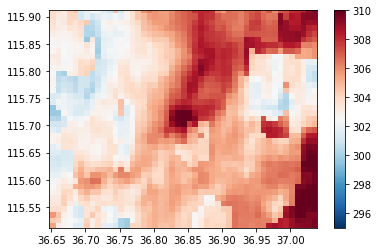

In [7]:
########################OBSERVATION POINT ################################################
#Check points by plotting
#specify x,y,LSTs
x= df_subset.Latitude
y= df_subset.Longitude
LST = df_subset.LST_day

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z, cmap ='RdBu_r', vmin = 295, vmax = 310)
plt.colorbar()

In [8]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map

#function for finding the UTM projection
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

#Get the UTM of the city
local_utm = CRS.from_proj4(utm_zoner(City_Lon, City_Lat))

#get geometry of the subset
df_subset_geometry = [Point(xy) for xy in zip(df_subset.Longitude, df_subset.Latitude)]

#transform into a geopandas dataframe
gdf = gpd.GeoDataFrame(df_subset, geometry=df_subset_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

gdf2 = gdf.to_crs(epsg=local_utm.to_epsg()).copy() #create a new geo dataframe, with units in m, cartesian 2D axis 

#origin coordinates - take to be city centre
#create a data frame with origin points
origin_df = pd.DataFrame(
    {'City': [CITY_COUNTRY],
     'Latitude': [City_Lat],
     'Longitude': [City_Lon]})

origin_df_geometry = [Point(xy) for xy in zip(origin_df.Longitude, origin_df.Latitude)]

origin_gdf = gpd.GeoDataFrame(origin_df, geometry=origin_df_geometry)

origin_gdf.crs= {'init': 'epsg:4326', 'no_defs': True}
origin_gdf = origin_gdf.to_crs(epsg=local_utm.to_epsg())

#Now change the grid so the the origin is the city centre 

#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

#and add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

#Determine the origin (city centre)
origin_x = origin_gdf['geometry'].x
origin_y = origin_gdf['geometry'].y

#Subtract the orgin from the points
gdf2['x_points'] = gdf2['xpoints'] - origin_x.values
gdf2['y_points'] = gdf2['ypoints'] - origin_y.values

#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)


Observation point 

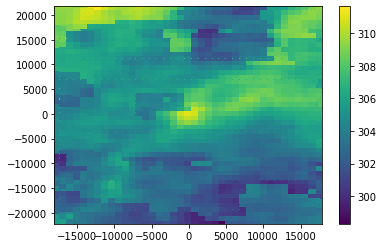

In [15]:
#################### OBSERVATION POINT #######################
#Check points by plotting
#specify x,y,LSTs
x= gdf2.x_points
y= gdf2.y_points
LST = gdf2.LST_day

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z)
plt.colorbar()

In [9]:
#Take a look at the quality of the data
#This should already be so that a specified number of pixels are usable (as image selection code checks this)
#to do this we will use the QC flag. The QC flag is a bit flag, so need to extract the relevent bytes, and select the data based on these
#first of all need to write a function to extract required bytes
#Then apply the function to the QC list to check bytes 1 and 2. Then append this new list onto our data frame.
#if the first 2 bytes are 0 then the quality is good. 

#Take the QC flags out the dataframe to apply the function to 
QC_day = gdf2.QC_day
QC_night = gdf2.QC_night

#Apply to function to QC
QC_day2 = np.array([quality_control(int(i)) for i in QC_day])
QC_night2 = np.array([quality_control(int(i)) for i in QC_night])


#And add this QC2 flag onto the dataset
gdf2['QC_day2'] = QC_day2
gdf2['QC_night2'] = QC_night2


Observation Point

Text(0, 0.5, 'Y distance')

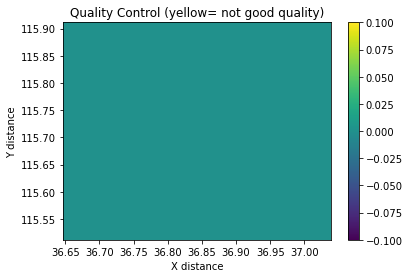

In [19]:
####  OBSERVATION POINT   #####

#Check the points which are not useable based on QC flag

#first grid the QC_2 flag
QC_2 = gdf2.QC_day2
QC_Z = scipy.interpolate.griddata((x, y), QC_2, (X,Y), method='nearest')

#Then plot 
plt.pcolormesh(X,Y,QC_Z)
plt.colorbar()
plt.title('Quality Control (yellow= not good quality)')
plt.xlabel('X distance')
plt.ylabel('Y distance')

In [63]:
#Generate the LULC dataframes in JASMIN, save as pickle to LULC pickles folder
#Now need to add in the land cover data in order to apply the urban mask
#Will apply the mask to the urban areas and the areas with QC2 flag = 1

yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 

#add in the urban classification
gdf2['is_urban'] = LULC_df['is_urban_overall_{}'.format(year)].values


#convert x and y points into km
gdf2['x_points'] /= 1000
gdf2['y_points'] /= 1000

#remove the pixels which are not of good quality from the dataset
#Separates into daytime good quality pixels and nightime good quality pixels 
gdf2_day_gq = gdf2[gdf2['QC_day2'] == 0].copy()
gdf2_night_gq = gdf2[gdf2['QC_night2'] == 0].copy()

#Now need to apply the urban mask
#take out the urban pixels and apply the linear regression

#Extract rural gdfs for the daytime and nighttime images
rural_day = gdf2_day_gq[gdf2_day_gq['is_urban'] == 0].copy()
#and drop unneeded columns
rural_day.drop(['LST_night','QC_day','QC_night','QC_day2','QC_night2','is_urban'], axis=1, inplace=True)

#do the same for night
rural_night = gdf2_night_gq[gdf2_night_gq['is_urban'] == 0].copy()
rural_night.drop(['LST_day','QC_day','QC_night','QC_day2','QC_night2','is_urban'], axis=1, inplace=True)

#will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
# LST = T0 + (a1)x + (a2)y
#T0, a1, a2 coefficients to be determined


In [64]:
#Perform regression
#Divide the data into attributes and labels

#rural daytime
X = rural_day[['x_points','y_points']].values
y = rural_day['LST_day'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#Look at the coefficients and intercept
X = pd.DataFrame(X) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
intercept = regressor.intercept_


#Now the regression has been created, this will be used to predict T_0
#This will give a baseline for what the temperature would be in the urban area if it was rural

#create the column T_0 with the predicted rural baseline temperatures

pred_input = gdf2_day_gq[['x_points','y_points']].values
gdf2_day_gq['T_0_pred'] = regressor.predict(pred_input)

#Take the predicted baseline temperature away from the LST to get the SUHI footprint 
gdf2_day_gq['SUHI'] = gdf2_day_gq['LST_day'] - gdf2_day_gq['T_0_pred']


#rural night time
X = rural_night[['x_points','y_points']].values
y = rural_night['LST_night'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#Look at the coefficients and intercept
X = pd.DataFrame(X) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
intercept = regressor.intercept_

#Now the regression has been created, this will be used to predict T_0
#This will give a baseline for what the temperature would be in the urban area if it was rural

#create the column T_0 with the predicted rural baseline temperatures

pred_input = gdf2_night_gq[['x_points','y_points']].values
gdf2_night_gq['T_0_pred'] = regressor.predict(pred_input)

#Take the predicted baseline temperature away from the LST to get the SUHI footprint 
gdf2_night_gq['SUHI'] = gdf2_night_gq['LST_night'] - gdf2_night_gq['T_0_pred']


#add in the column containing the logs
#There are two options for dealing with the negative results

#1 For the negative results, take -ln(abs(SUHI))
#define the function to take logs

def apply_ln(x):
    if x > 0:
         return np.log(x)
    else:
        return - np.log(abs(x))

#add in the ln SUHI columns 
SUHI = gdf2_day_gq['SUHI']
ln_SUHI = np.array([apply_ln(x) for x in SUHI])
gdf2_day_gq['ln_SUHI'] = ln_SUHI

SUHI = gdf2_night_gq['SUHI']
ln_SUHI = np.array([apply_ln(x) for x in SUHI])
gdf2_night_gq['ln_SUHI'] = ln_SUHI


In [108]:
#Polynomial regression
#equation is of form ln_SUHI = b1 (x^2) +b2 xy +b3 y^2 + b4 x + b5 y + b6

#set variables to use
#Divide the data into attributes and labels
#Can also Divide x points y points by 100 to get bigger coefficient (add in /100)

X = gdf2_day_gq[['x_points','y_points']].values
poly= PolynomialFeatures(degree=2) #
X_poly = poly.fit_transform(X)      #generate the polynomial and interaction feature in form [1, a, b, a^2, ab, b^2]
                                    #so column 0:1 c1:x c2:y c3:x^2 c4: xy c5:y^2

y = gdf2_day_gq['ln_SUHI'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size= 0.2, random_state = 0) # note: Shuffle = True by default

#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#Look at the coefficients and intercept
Xpoly = pd.DataFrame(X_poly) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, Xpoly.columns, columns=['Coefficient'])  
intercept = regressor.intercept_

beta = regressor.coef_
beta = np.append(beta, intercept)
beta = beta[1:]

In [109]:
beta

array([ 0.00078811, -0.00377895,  0.00071454, -0.00038577, -0.00098549,
        0.10618489])

In [112]:
#Solve the simultaneous equations to get the initial guess parameters
#Levenberg-Marquardt method used

def fun(x):
    # x = [x0, y0, lna0, ax, ay, phi]
    # contains the equations to solve
    cphi = np.cos(x[5])
    sphi = np.sin(x[5])
    ax2 = x[3]**2
    ay2 = x[4]**2
    return [
        beta[0] - (-2*cphi**2/ax2 - 2*sphi**2/ay2),                                                            #beta 1
        beta[1] - (-4*cphi*sphi/ax2 + 4*cphi*sphi/ay2),                                                        #beta 2
        beta[2] - (-2*sphi**2/ax2 - 2*cphi**2/ay2),                                                            #beta 3
        beta[3] - (4*x[0]*cphi**2/ax2 + 4*x[1]*cphi*sphi/ax2 - 4*x[1]*cphi*sphi/ay2 + 4*x[0]*sphi**2/ay2),     #beta 4
        beta[4] - (4*x[0]*cphi*sphi/ax2 + 4*x[1]*cphi**2/ax2 + 4*x[1]*cphi**2/ay2 - 4*x[0]*cphi*sphi/ay2),     #beta 5
        beta[5] - (x[2] - (2/ax2)*((x[0]**2)*cphi**2 + 2*x[0]*x[1]*cphi*sphi + (x[1]**2)*sphi**2)              #beta 6
                   - (2/ay2)*((x[1]**2)*cphi**2 - 2*x[0]*x[1]*cphi*sphi + (x[0]**2)*sphi**2))

    ]

def jac(x):
    #jacobian- matrix containing the partial derivatives
    cphi = np.cos(x[5])
    sphi = np.sin(x[5])
    cphi2 = cphi**2
    sphi2 = sphi**2
    ax2 = x[3]**2
    ay2 = x[4]**2
    ax3 = x[3]**3
    ay3 = x[4]**3
    x0 = x[0]
    y0 = x[1]
    return np.array([
        # partial derivatives
        
        [0, 0, 0, 4*cphi2/ax3, 4*sphi2/ay3, 4*sphi*cphi/ax2 - 4*cphi*sphi/ay2], 
        
        [0, 0, 0, 8*cphi*sphi/ax3, 8*cphi*sphi/ay3, (-8/ax2 - 8/ay2)*(cphi2 - sphi2)],
        
        [0, 0, 0, 4*sphi2/ax3, 4*cphi2/ay3, -4*sphi*cphi/ax2 + 4*sphi*cphi/ay2],
        
        [4*cphi2/ax2 + 4*sphi2/ay2, 4*cphi*sphi/ax2-4*cphi*sphi/ay2, 0, -8*x0*cphi2/ax3 - 8*y0*cphi*sphi, 8*y0*cphi*sphi/ay3 - 8*x0*sphi2/ay3, 
         -8*x0*cphi*sphi/ax2 + (4*y0/ax2-4*y0/ay2)*(cphi2 - sphi2) + 8*x0*sphi*cphi/ay2],
        
        [4*cphi*sphi*(1/ax2 - 1/ay2), 4*sphi2/ax2 + 4*cphi/ay2, 0, -8*x0*cphi*sphi/ax3 - 8*y0*sphi2/ax3, 
         -8*y0*cphi2/ay3 + 8*x0*cphi*sphi/ay3, (1/ax2-1/ay2)*4*x0*(sphi2-cphi2) + (1/ax2-1/ay2)*(16*y0*cphi*sphi)],
        
        [-(2/ax2)*(2*x0*cphi2+2*y0*cphi*sphi)-(2/ay2)*(2*x0*sphi2-2*y0*cphi*sphi), -(2/ax2)*(2*x0*cphi*sphi+2*y0*sphi2)-(2/ay2)*(2*y0*cphi2-2*x0*cphi*sphi),
        1, (4/ax3)*(x0**2*cphi2 + 2*x0*y0*cphi*sphi+y0**2*sphi2), (4/ay3)*(y0**2*cphi2 - 2*x0*y0*cphi*sphi + x0**2*sphi2),
        (-2/ax2)*(-2*x0**2*cphi*sphi + 2*x0*y0*(cphi2-sphi2)+2*y0**2*cphi*sphi) - (2/ay2)*(-2*y0**2*cphi*sphi - 2*x0*y0*(cphi2-sphi2)+2*x0**2*cphi*sphi)]
        
        ])

guess = 10
x0 = np.array([guess,guess,guess,guess,guess,guess])
#x0 = np.array([0.7,0.7,1.5,8,8,-0.5])
#sol = optimize.root(fun, x0, jac=jac, tol=1e-35, method='lm', options=dict(eps=1e-6))
sol = optimize.root(fun, x0, jac=jac, tol=1e-35, options=dict(eps=1e-6))

#sol = scipy.optimize.diagbroyden(fun, x0)


# x = [x0, y0, lna0, ax, ay, phi] 


In [113]:
sol

    fjac: array([[-3.83505813e-09, -4.32772311e-09, -4.61278969e-09,
         6.24223267e-04, -1.12864460e-06,  9.99999805e-01],
       [-8.08722890e-06, -8.54716328e-07, -8.10134012e-06,
         4.06990456e-02, -9.99171450e-01, -2.65330059e-05],
       [-1.70506541e-04, -5.96353131e-06, -1.70214072e-04,
         9.99171226e-01,  4.06990558e-02, -6.23660116e-04],
       [-4.99454409e-01,  4.74080502e-01, -7.25115804e-01,
        -2.05974434e-04,  1.12637461e-06,  1.25366775e-07],
       [ 1.56998830e-01,  8.72658860e-01,  4.62404443e-01,
         1.10823974e-04, -1.25226286e-06, -6.26686287e-08],
       [-8.51995676e-01, -1.17107608e-01,  5.10283424e-01,
        -5.91790582e-05,  4.48237523e-07,  3.55210258e-08]])
     fun: array([ 2.07881055e-02, -3.77894914e-03,  2.07145373e-02, -4.00385769e-01,
       -5.64218313e-01, -5.89381511e+00])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 11
    njev: 2
   

In [110]:
#Fit to the Gaussian surface 

def SUHIfunc(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    return a0 * np.exp(((-((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))**2)/(0.5*(ax**2)))-((((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi))**2)/(0.5*(ay**2))))

#jacobian not used atm, the shape is wrong
def jac(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    ax2 = ax**2
    ay2 = ay**2
    cphi = np.cos(phi)
    sphi = np.sin(phi)
    cphi2 = cphi**2
    sphi2 = sphi**2
    SUHIeq = SUHIfunc(Z,a0,x0,y0,phi,ax,ay)
    return np.array([
        [SUHIeq/a0] , [((-4/ax2)*((x0-x)*cphi2 + (y0-y)*sphi*cphi) - ((4/ay2)* ((y0-y)*cphi*sphi) + (x0-x)*cphi*sphi))*SUHIeq] , 
                     
        [((-4/ax2)*((x0-x)*cphi*sphi + (y0-y)*sphi2) - ((4/ay2)* ((y0-y)*cphi2) - (x0-x)*cphi*sphi))*SUHIeq] , [((4/(ax**3))*((x-x0)*cphi+(y-y0)*sphi)**2)*SUHIeq] , 
         
        [((4/(ay**3))*((y-y0)*cphi-(x-x0)*sphi)**2)*SUHIeq ], 
         
        [((-4/ax2)*((x-x0)*cphi + (y-y0)*sphi)*((x0-x)*sphi+(y-y0)*cphi) - (4/ay2) *((y-y0)*cphi - (x-x0)*sphi)*((y0-y)*sphi-(x-x0)*cphi))*SUHIeq] 
        ])
                                  
                     
# data
#daytime SUHI
x = gdf2_day_gq['x_points'].values
y = gdf2_day_gq['y_points'].values
z = gdf2_day_gq['SUHI'].values

# initial guesses for a0,x0,y0,phi,ax,ay:
#a0, x0, y0, phi, ax, ay = 6., 6., 6., 0.5., 3., 3.
p0 = 1,1,1,0.1,20,20
#p0 = 2., -1.3, 4, -0.6, 100., 250. 
#p0 = 2.5, -1.3, 4, -0.6, 100., 250. 
popt, pcov = curve_fit(SUHIfunc, (x,y), z, p0, maxfev=5000, jac = None)
perr = np.sqrt(np.diag(pcov)) #standard deviation on parameters

In [111]:
popt

array([ 3.93638121e+00,  5.93832317e+00,  2.20012462e+00, -1.97074835e+05,
        1.84969487e+01,  5.80190371e+00])

Observation points- rural linear regression 

Text(0.5, 1.0, 'Urban Pixels (yellow)')

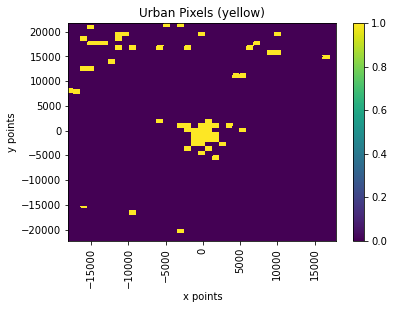

In [31]:
####  OBSERVATION POINT   #####

#Look at urban land cover
#get the points into the correct format
x_lu = gdf2['x_points'].values
y_lu = gdf2['y_points'].values
U_lu = gdf2['is_urban'].values

X_lu,Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), U_lu, (X_lu,Y_lu), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X_lu,Y_lu, Z_lu)
plt.colorbar()
plt.xlabel('x points')
plt.xticks(rotation=90)
plt.ylabel('y points')
plt.title('Urban Pixels (yellow)')

Text(0, 0.5, 'LST_night')

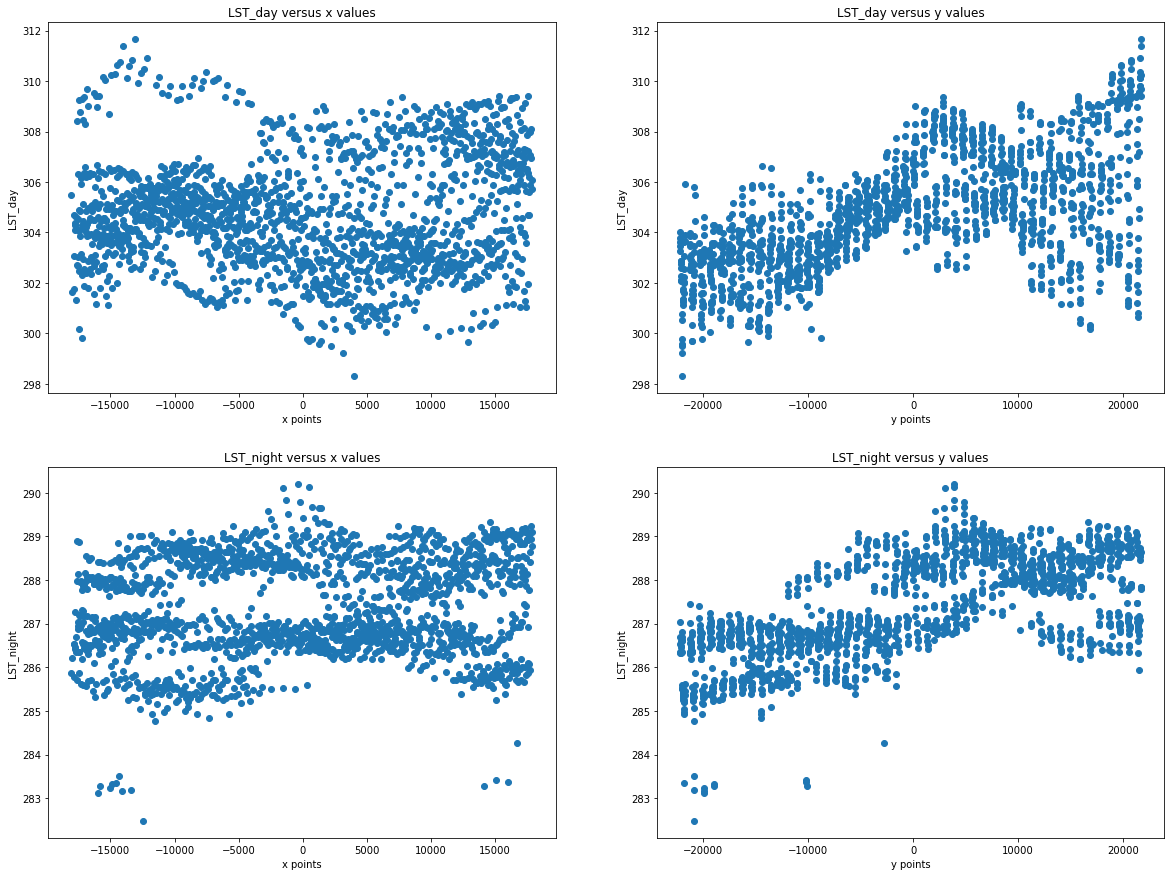

In [59]:
####  OBSERVATION POINT   #####

#First want to look at the distribution of the data to check it satisfies the criteria for a linear regression to be applied 
#Look at distribution for x distance

fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 15))

LST_day = rural_day['LST_day'].values
x_day = rural_day['x_points'].values 
y_day = rural_day['y_points'].values 

LST_night = rural_night['LST_night'].values
x_night = rural_night['x_points'].values 
y_night = rural_night['y_points'].values 

plt.subplot(2, 2, 1)
plt.scatter(x_day, LST_day)
plt.title('LST_day versus x values')
plt.xlabel('x points')
plt.ylabel('LST_day')

plt.subplot(2, 2, 2)
plt.scatter(y_day, LST_day)
plt.title('LST_day versus y values')
plt.xlabel('y points')
plt.ylabel('LST_day')

plt.subplot(2, 2, 3)
plt.scatter(x_night, LST_night)
plt.title('LST_night versus x values')
plt.xlabel('x points')
plt.ylabel('LST_night')

plt.subplot(2, 2, 4)
plt.scatter(y_night, LST_night)
plt.title('LST_night versus y values')
plt.xlabel('y points')
plt.ylabel('LST_night')


<AxesSubplot:title={'center':'Distribution of rural night LST'}, xlabel='LST_night', ylabel='Density'>

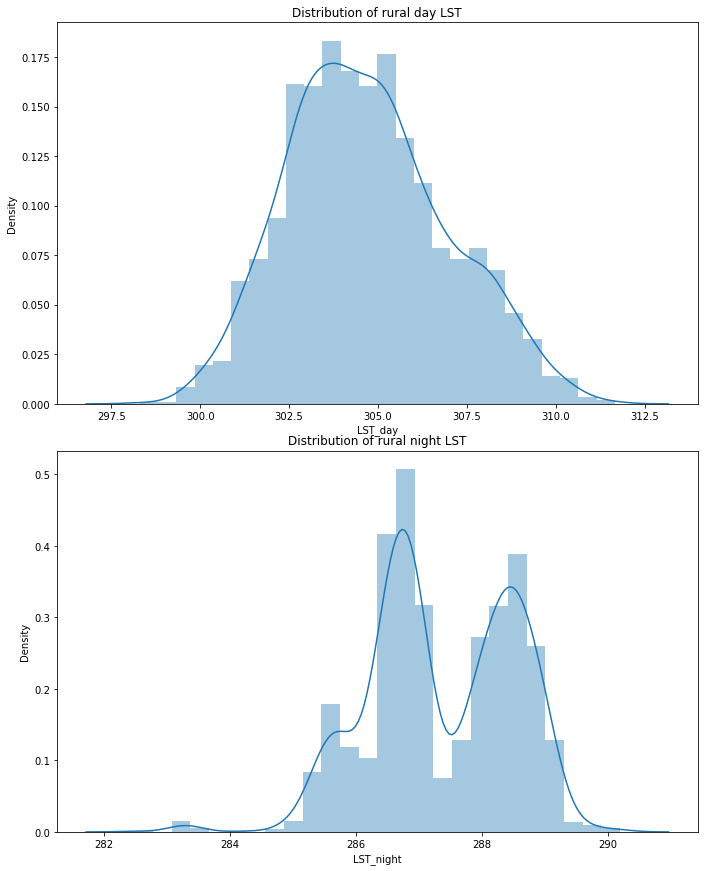

In [72]:
###### OBSERVATION POINT ###############################
import seaborn as sns

plt.figure(figsize=(10,12))

plt.subplot(2,1,1)
plt.tight_layout()
plt.title('Distribution of rural day LST')
plt.xlabel('Day LST')
plt.ylabel('Density') 
sns.distplot(rural_day['LST_day'])

plt.subplot(2,1,2)
plt.tight_layout()
plt.title('Distribution of rural night LST')
plt.xlabel('Night LST')
plt.ylabel('Density') 
sns.distplot(rural_night['LST_night'])


In [73]:
##################### OBSERVATION POINT ################################################
#Perform stats tests
#perform a ks test to see if the distribution of LST is normal
from scipy.stats import norm, kstest
#x is a list of the LSTs
x= rural_day['LST_day'].tolist()

#generate what the normal distribution parameters of this would be 
loc, scale = norm.fit(x)
n=norm(loc=loc, scale=scale)

ks_result = stats.kstest(x, n.cdf)

#Result: KstestResult(statistic=0.061, pvalue=0.0055)

#perform a shapiro wilks test
shapiro_result = stats.shapiro(x)

#Result: 0.97, 1.84e-10

print("ks_test", ks_result)
print("shapiro_test", shapiro_result)      

ks_test KstestResult(statistic=0.043261330286952226, pvalue=0.0024410653846691755)
shapiro_test ShapiroResult(statistic=0.989397406578064, pvalue=3.888567245979857e-10)


Observation points for the log linear regression

[Text(0.5, 0, 'y distance'), Text(0, 0.5, 'ln(SUHI)')]

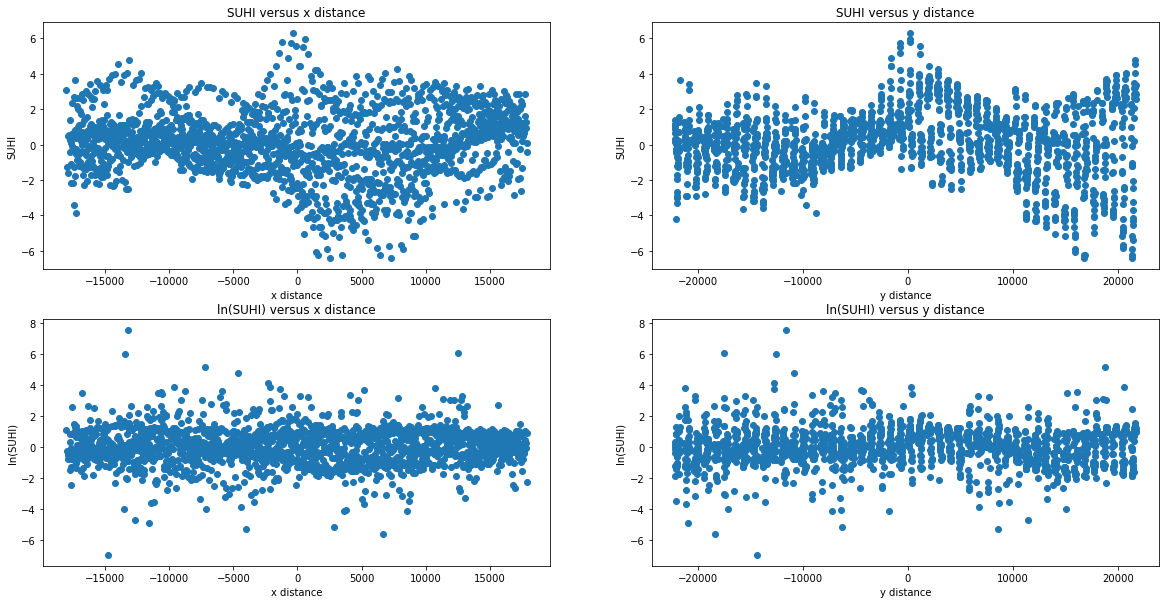

In [42]:
####  OBSERVATION POINT   #####

#Scatterplots
#Look at distribution for x and y distances
#Look at the day SUHI

x_points = gdf2_day_gq['x_points']
y_points = gdf2_day_gq['y_points']
SUHI = gdf2_day_gq['SUHI']
ln_SUHI = gdf2_day_gq['ln_SUHI']

fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 10))

axes[0,0].scatter(x_points, SUHI)
axes[0,0].set_title('SUHI versus x distance')
axes[0,0].set(xlabel = 'x distance', ylabel = 'SUHI')

axes[0,1].scatter(y_points, SUHI)
axes[0,1].set_title('SUHI versus y distance')
axes[0,1].set(xlabel = 'y distance', ylabel = 'SUHI')

axes[1,0].scatter(x_points, ln_SUHI)
axes[1,0].set_title('ln(SUHI) versus x distance')
axes[1,0].set(xlabel = 'x distance', ylabel = 'ln(SUHI)')

axes[1,1].scatter(y_points, ln_SUHI)
axes[1,1].set_title('ln(SUHI) versus y distance')
axes[1,1].set(xlabel = 'y distance', ylabel = 'ln(SUHI)')

[Text(0.5, 0, 'y distance'), Text(0, 0.5, 'ln(SUHI)')]

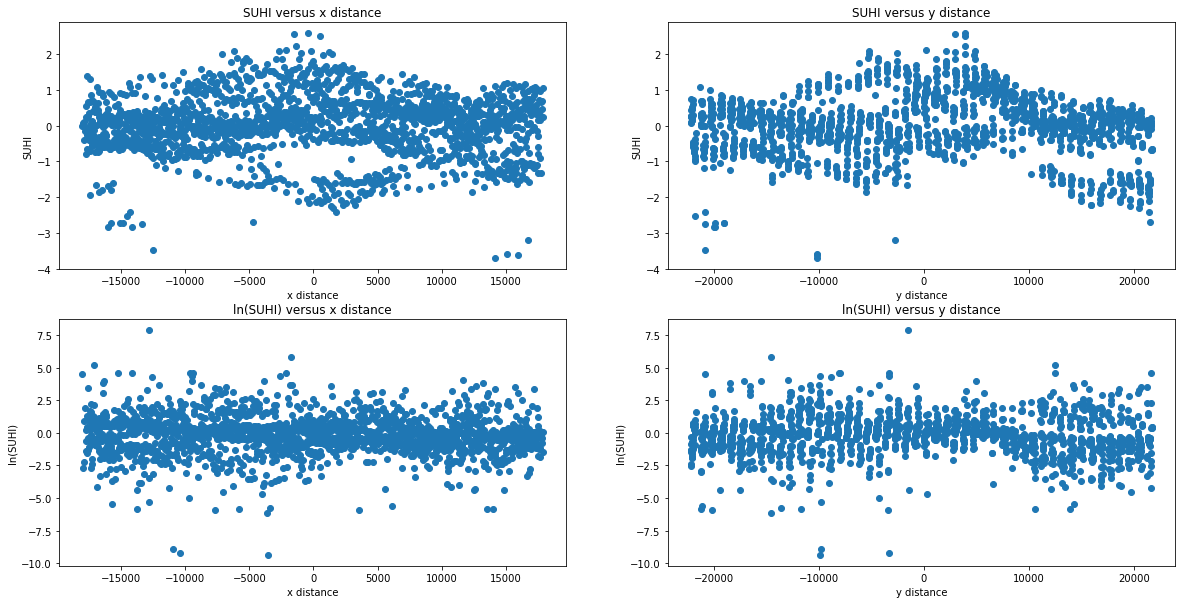

In [43]:
####  OBSERVATION POINT   #####

#Scatterplots
#Look at distribution for x and y distances
#Look at the day SUHI

x_points = gdf2_night_gq['x_points']
y_points = gdf2_night_gq['y_points']
SUHI = gdf2_night_gq['SUHI']
ln_SUHI = gdf2_night_gq['ln_SUHI']

fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 10))

axes[0,0].scatter(x_points, SUHI)
axes[0,0].set_title('SUHI versus x distance')
axes[0,0].set(xlabel = 'x distance', ylabel = 'SUHI')

axes[0,1].scatter(y_points, SUHI)
axes[0,1].set_title('SUHI versus y distance')
axes[0,1].set(xlabel = 'y distance', ylabel = 'SUHI')

axes[1,0].scatter(x_points, ln_SUHI)
axes[1,0].set_title('ln(SUHI) versus x distance')
axes[1,0].set(xlabel = 'x distance', ylabel = 'ln(SUHI)')

axes[1,1].scatter(y_points, ln_SUHI)
axes[1,1].set_title('ln(SUHI) versus y distance')
axes[1,1].set(xlabel = 'y distance', ylabel = 'ln(SUHI)')